We'll look at the same dataset as in hard_clustering_example, but with different mathematical predictions. A soft clustering model (simple gaussian mixture model) is used and that means that each data point is given a vector of probabilities instead of a single predicted class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture

from clustervisualizer.ClusterAnalyzer import ClusterAnalyzer as clust

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'type']


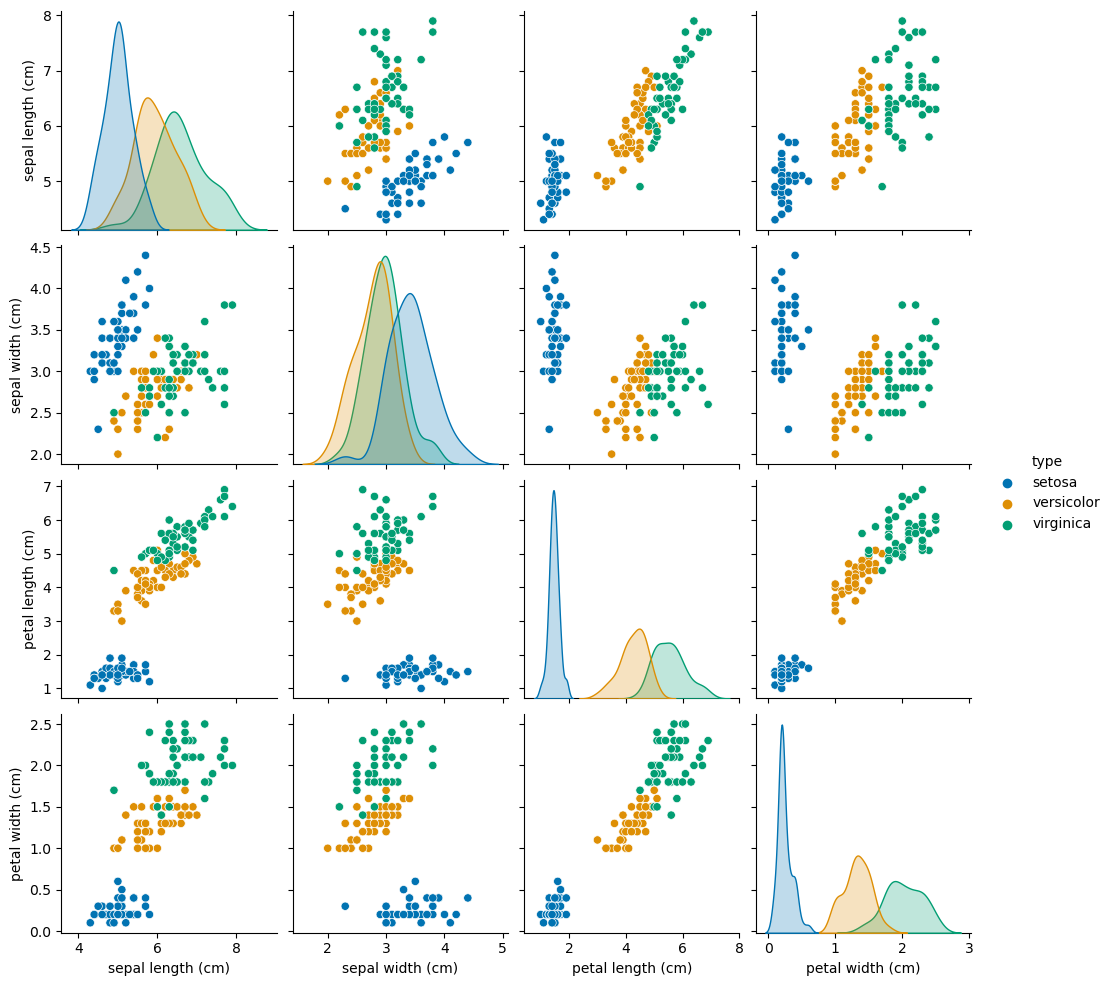

In [2]:
# Load iris data set ...
X, y = load_iris(as_frame=True, return_X_y=True)
# ... and add flower type to X dataframe
type_dict = { 0 : 'setosa',
              1 : 'versicolor',
              2 : 'virginica' }
X['type'] = [ type_dict[elem] for elem in y ]


# See data labels available
print( list(X) )


# Visualize correct distribution of flower cluster
sns.pairplot(X, hue='type', palette='colorblind')

In [3]:
# Cluster data using Gaussian mixture
fit_params = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
gm = GaussianMixture(n_components=3, random_state=1).fit( X[fit_params] )
gm_preds = gm.predict_proba( X[fit_params] )

Let's analyze the probability distribution of each cluster 

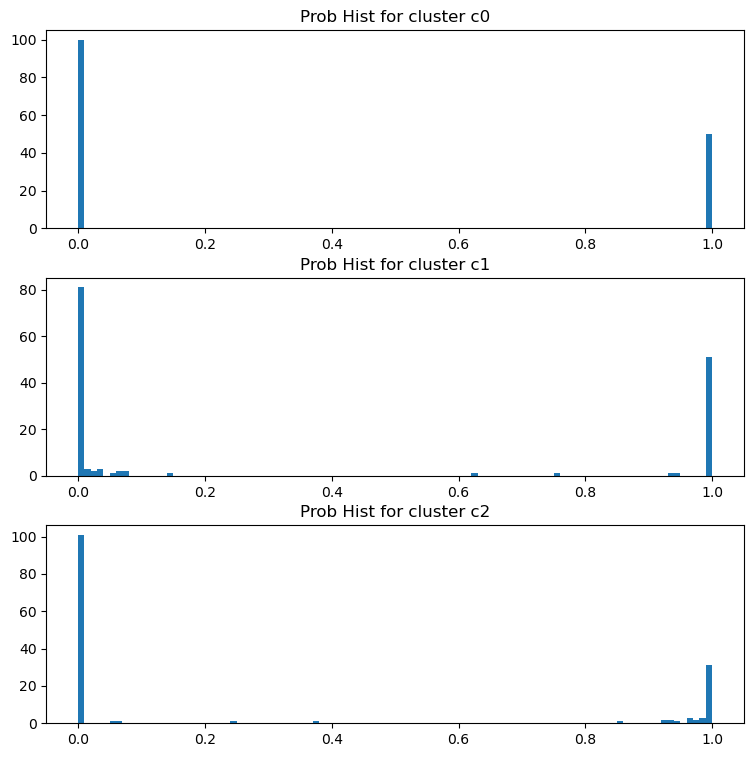

In [4]:
fig, axes = plt.subplots(3,1, figsize=(9,9))
for i in range( len(axes) ):
    axes[i].hist( gm_preds[:,i], bins=100 )
    axes[i].set_title( 'Prob Hist for cluster c'+str(i) )
fig.subplots_adjust(hspace=0.25)

Cluster c0 is practically binary (all predictions are almost 1 or 0), but clusters c1 and c2 have some slight measure of overlap (with probabilities between 0.05 and 0.95).

Let's analyze the predictions using ClusterAnalyzer. We can't depict in-cluster histograms on top of full-data histograms like in the hard clustering example because what it means to be "in the cluster" is not exactly defined (is any point with >= 90% cluster probability "in the cluster", or >= 75% instead?). What *can* be done is to create a histogram for a feature, take the resulting bins and compute average cluster probabilities between the bins

As a short example, let's say we have the bin values [0, 1, 2, ..., 9, 10]. To depict the soft clustering equivalent of an in-cluster histogram for some feature (call it "foo"), we would ...

    (1) compute the histogram for foo
    (2) for each pair of adjacent bins (e.g. [0,1], [5,6], ...):
        (2a) take all data falling between those bin values
        (2b) compute the average probability for those data,
        (2c) plot that average probability on top of the corresponding histogram bar.
        
Using simultaneous y axes (one at left for the histogram count and the other at right for the probability value), we can depict in-cluster histograms like so.

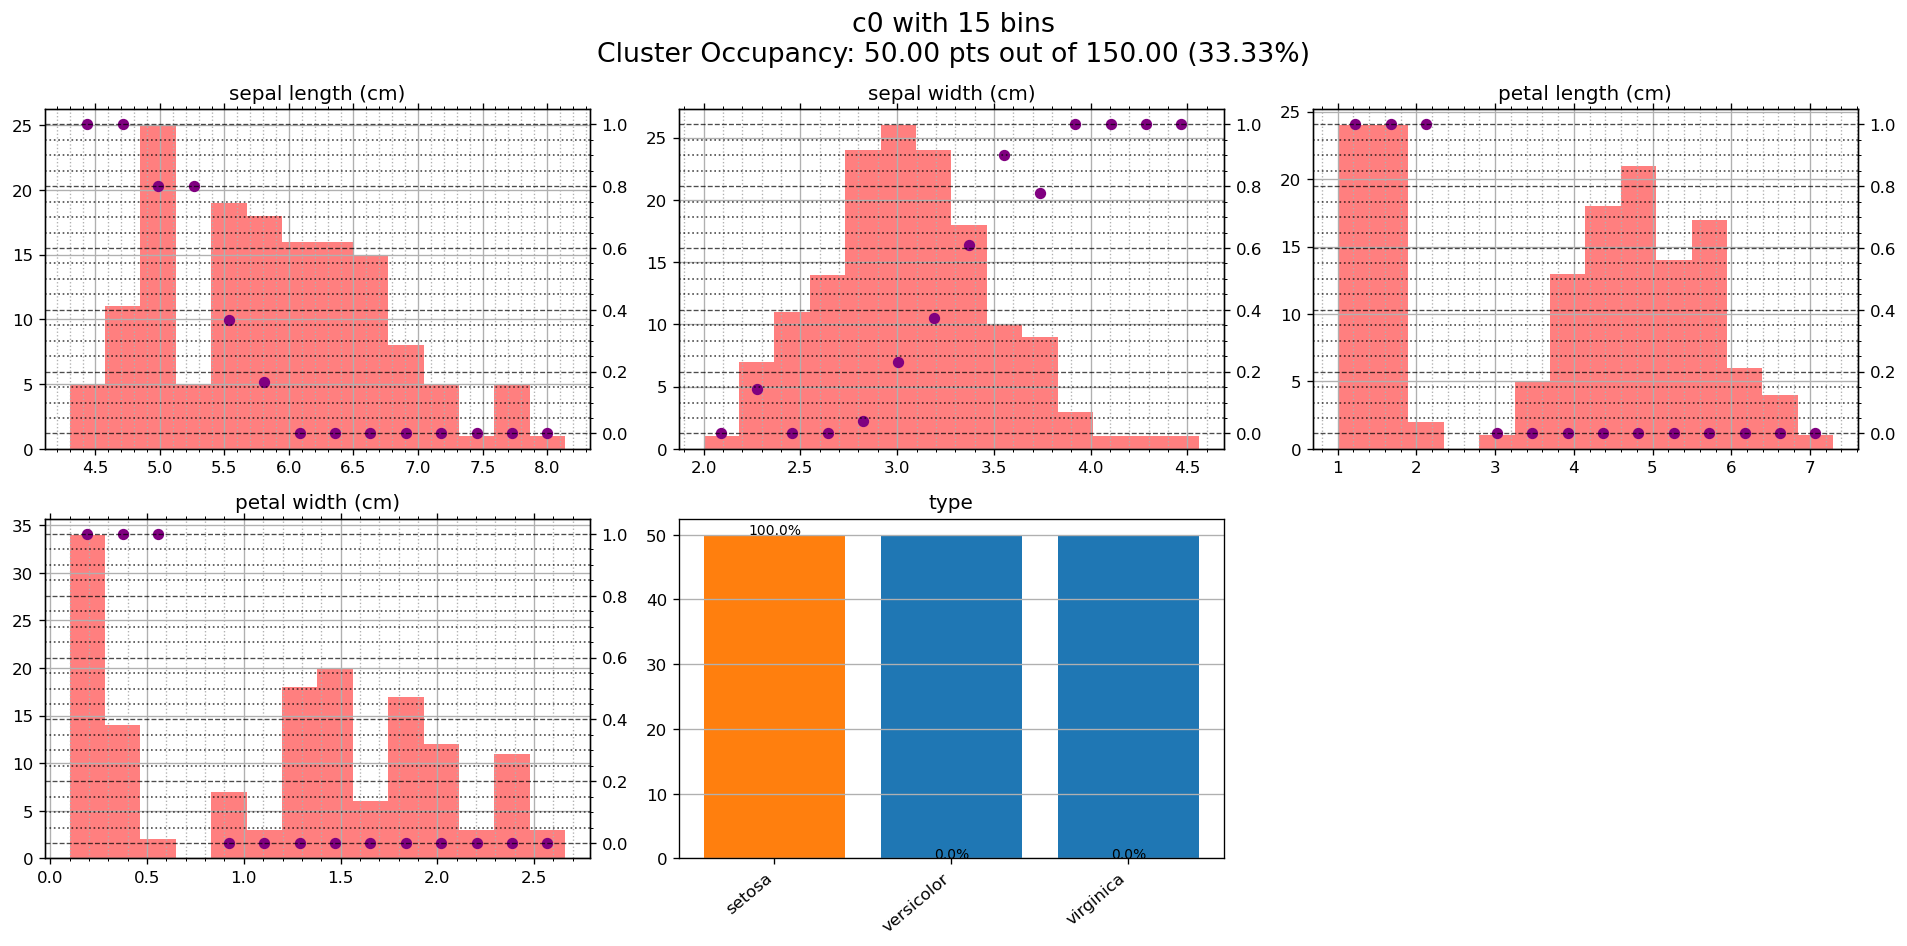

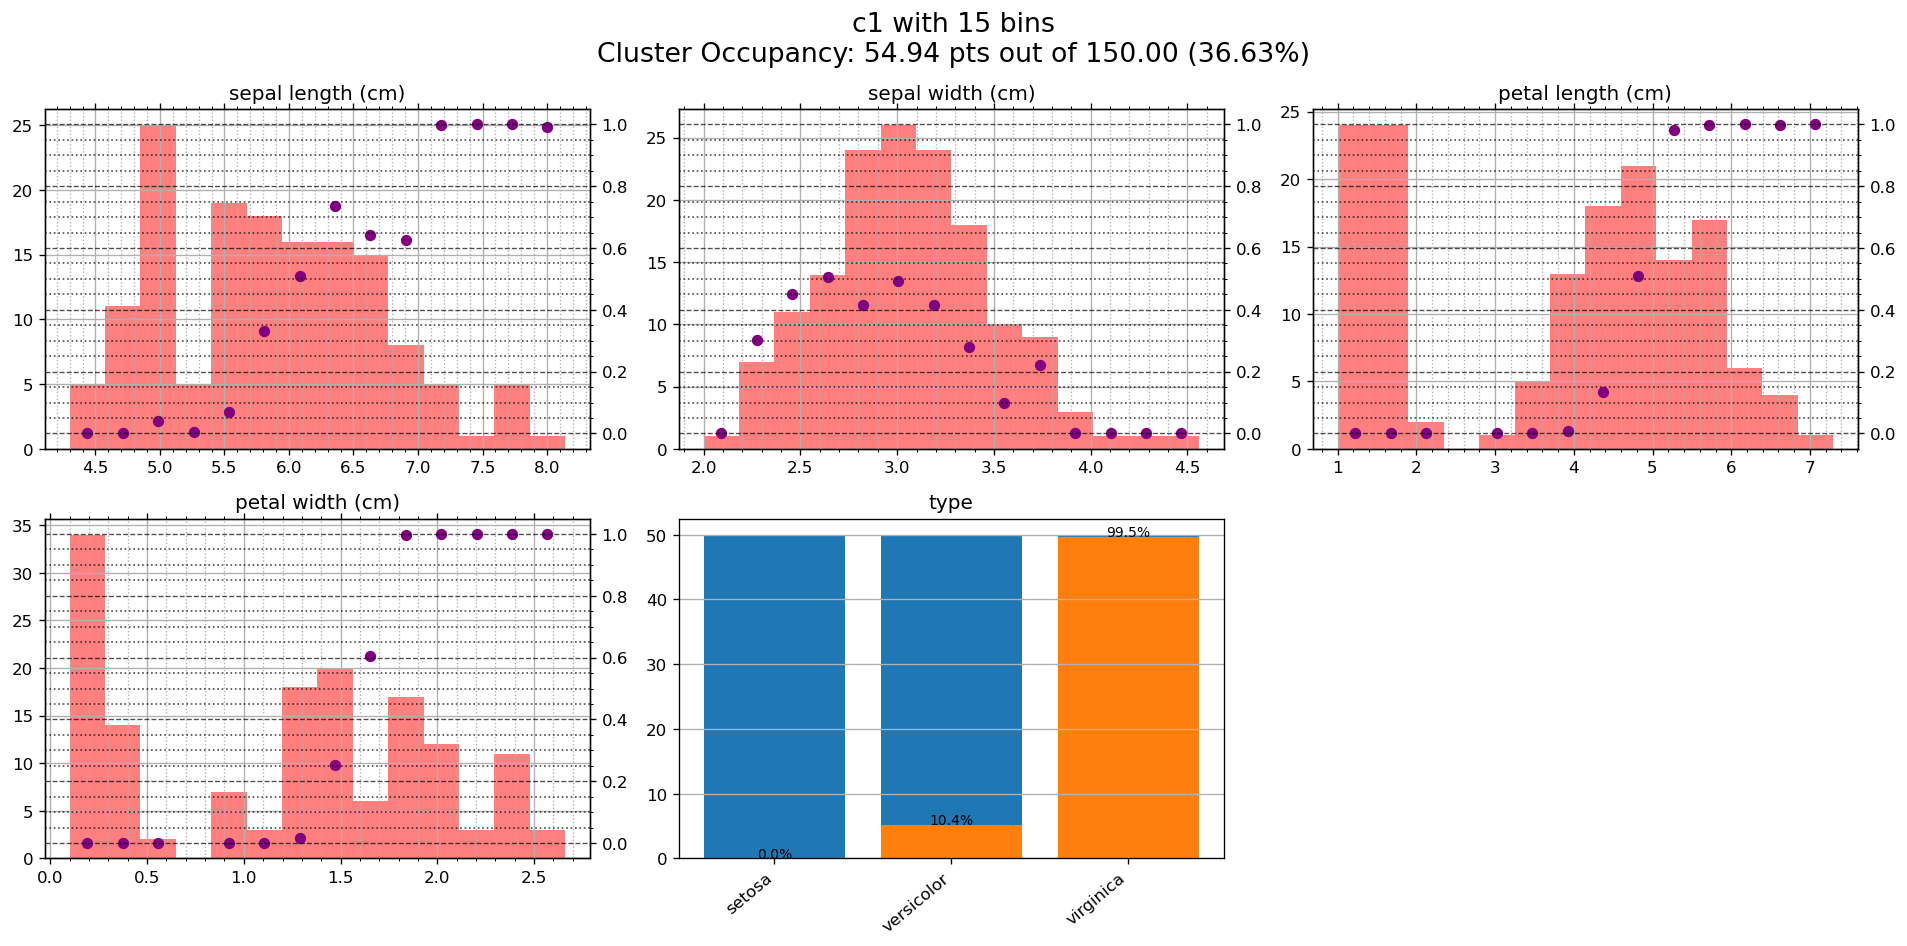

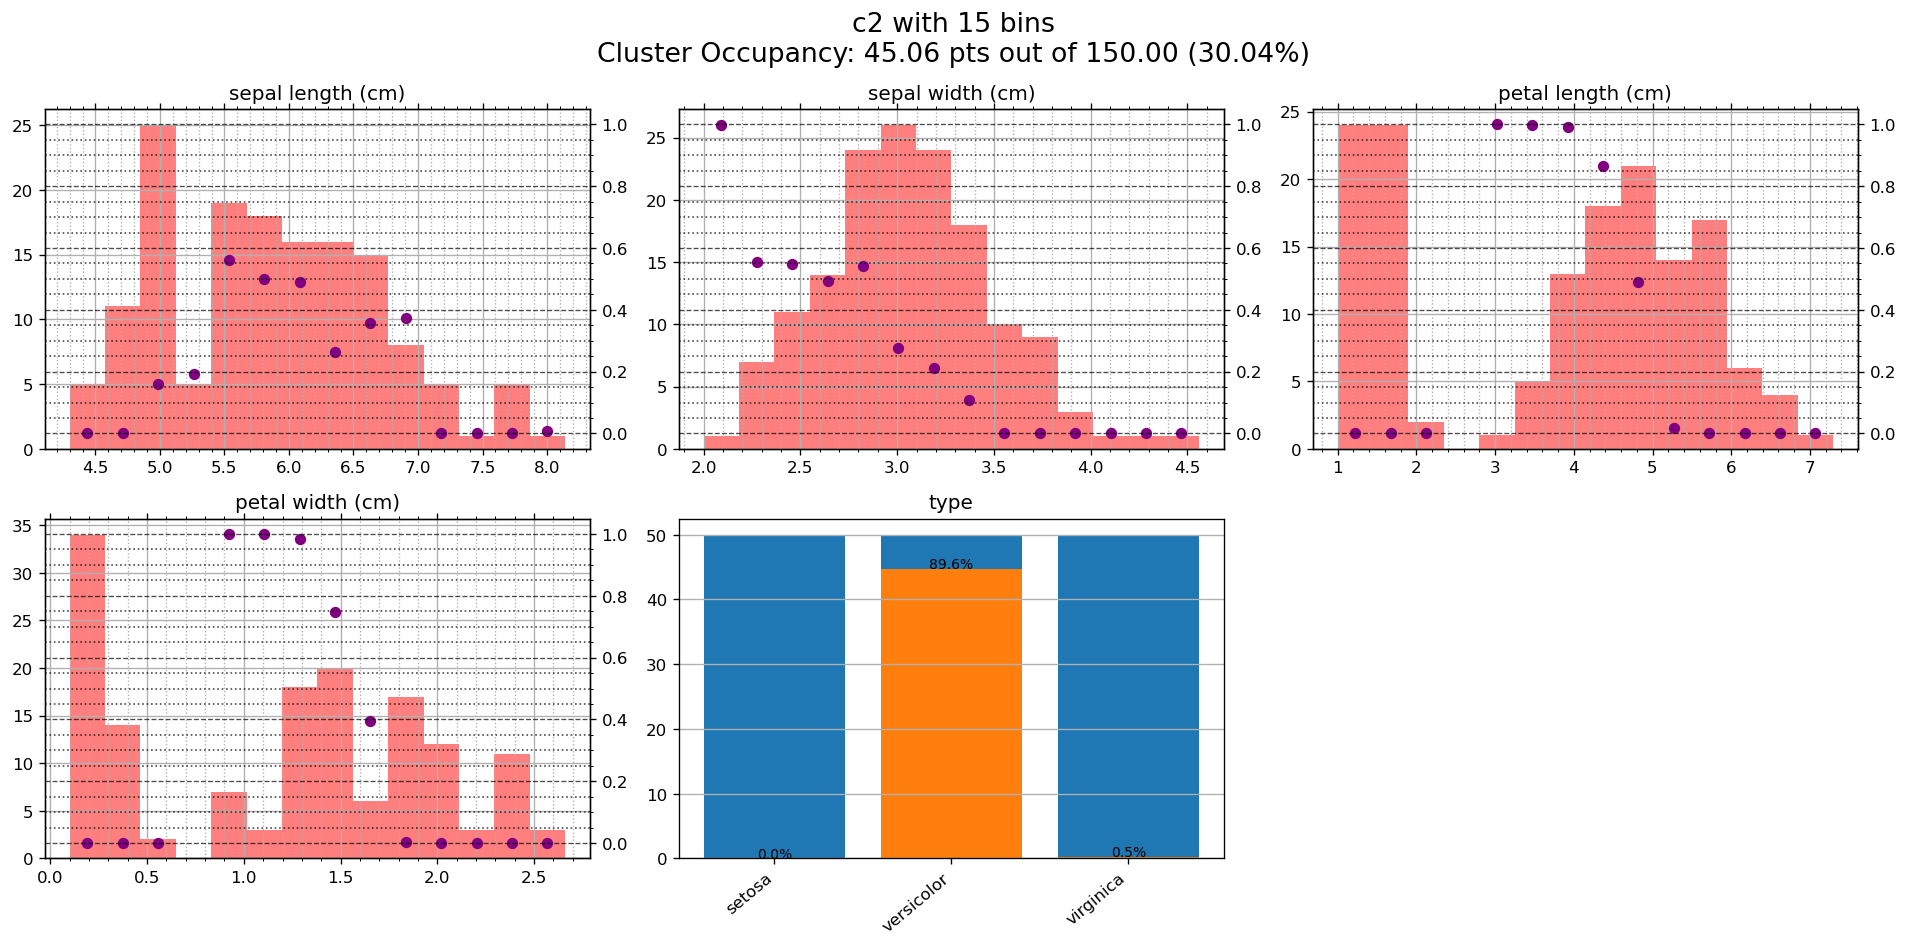

In [5]:
# Instantiate ClusterAnalyzer
clust1 = clust(
            X,   # dataframe to analyze
            gm_preds   # 2d array of predictions (in this case)
              )

# Create histograms
hist_vars = [ *fit_params, 'type' ]
clust1.hist1d(hist_vars=hist_vars,
              bins=15)

It's worth noting that bin values with no associated probabilities have no plotted point because there's nothing to average (see bins between 2.4 and 2.8 in the petal length histograms).

Clusters can named using either the rename_clusters functon (after class instantiation) or in the constructor itself. The way the latter is computed is mathematically different from hard clustering and is done by computing the expectation value (or the weighted product of whichever function is given), but is syntactically similar to the hard clustering example.

In [6]:
# same as in hard clustering
clust1.rename_clusters({'c0':'predicted_setosa',
                        'c1':'predicted_virginica',
                        'c2':'predicted_versicolor'})

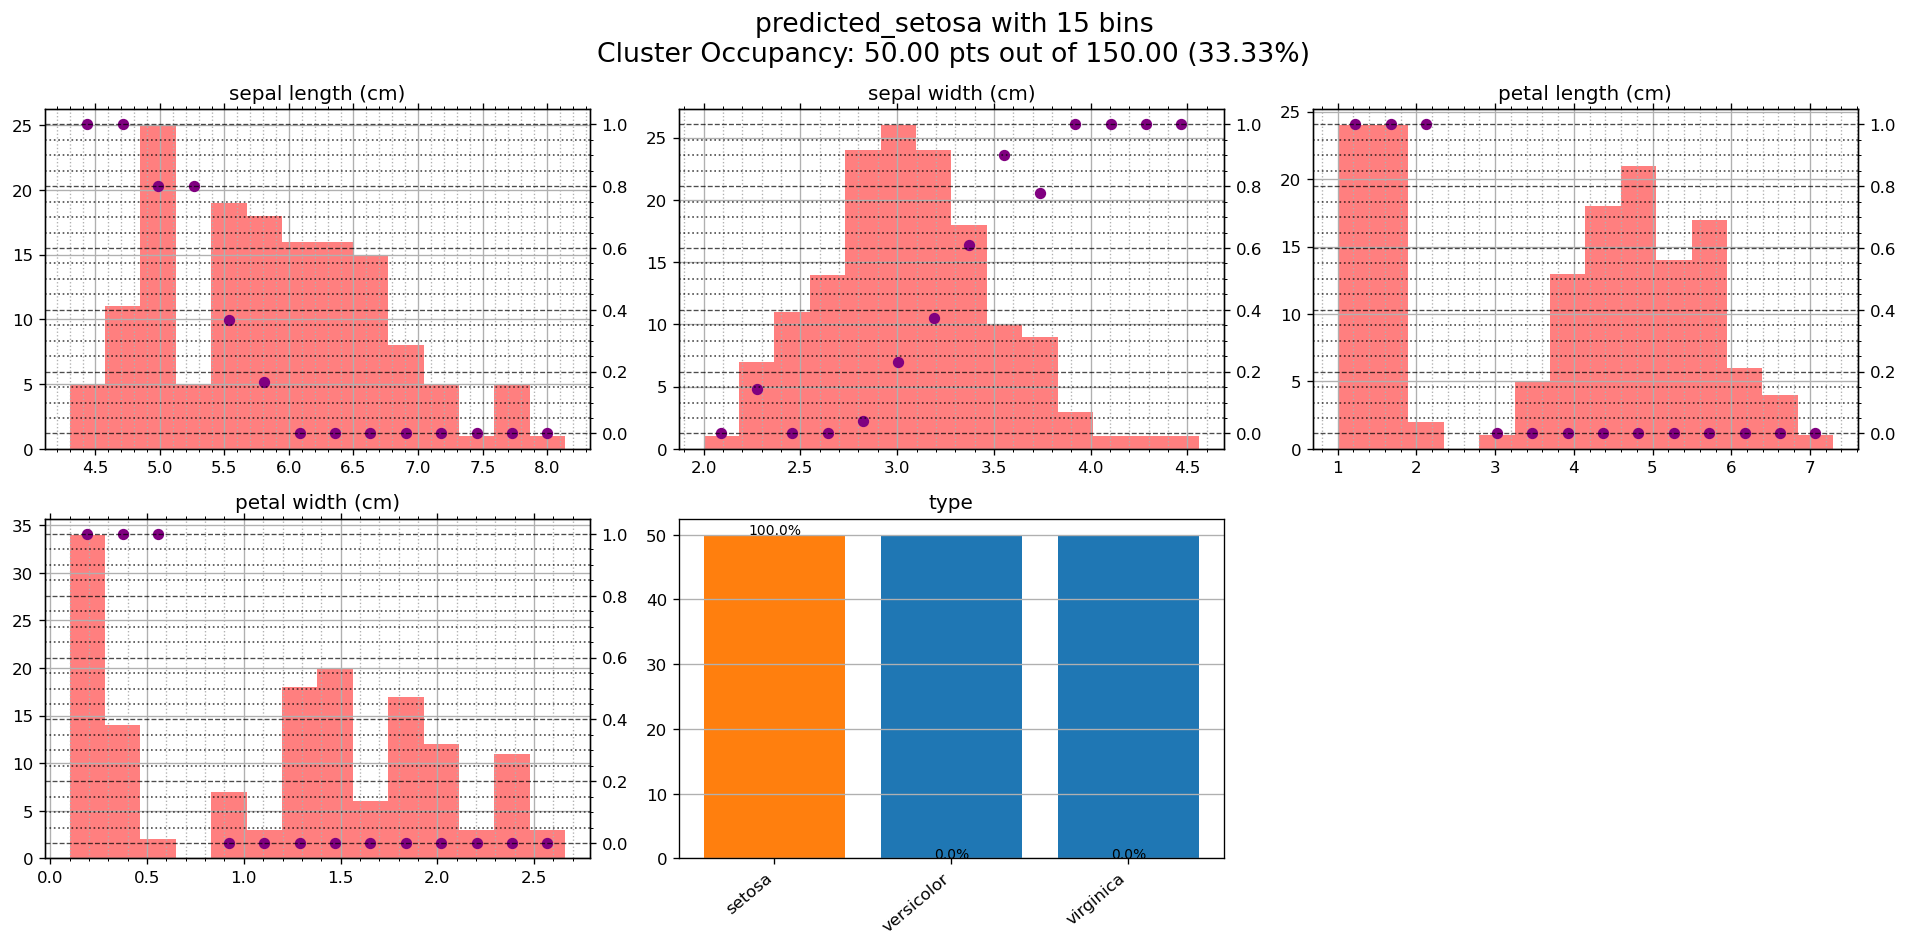

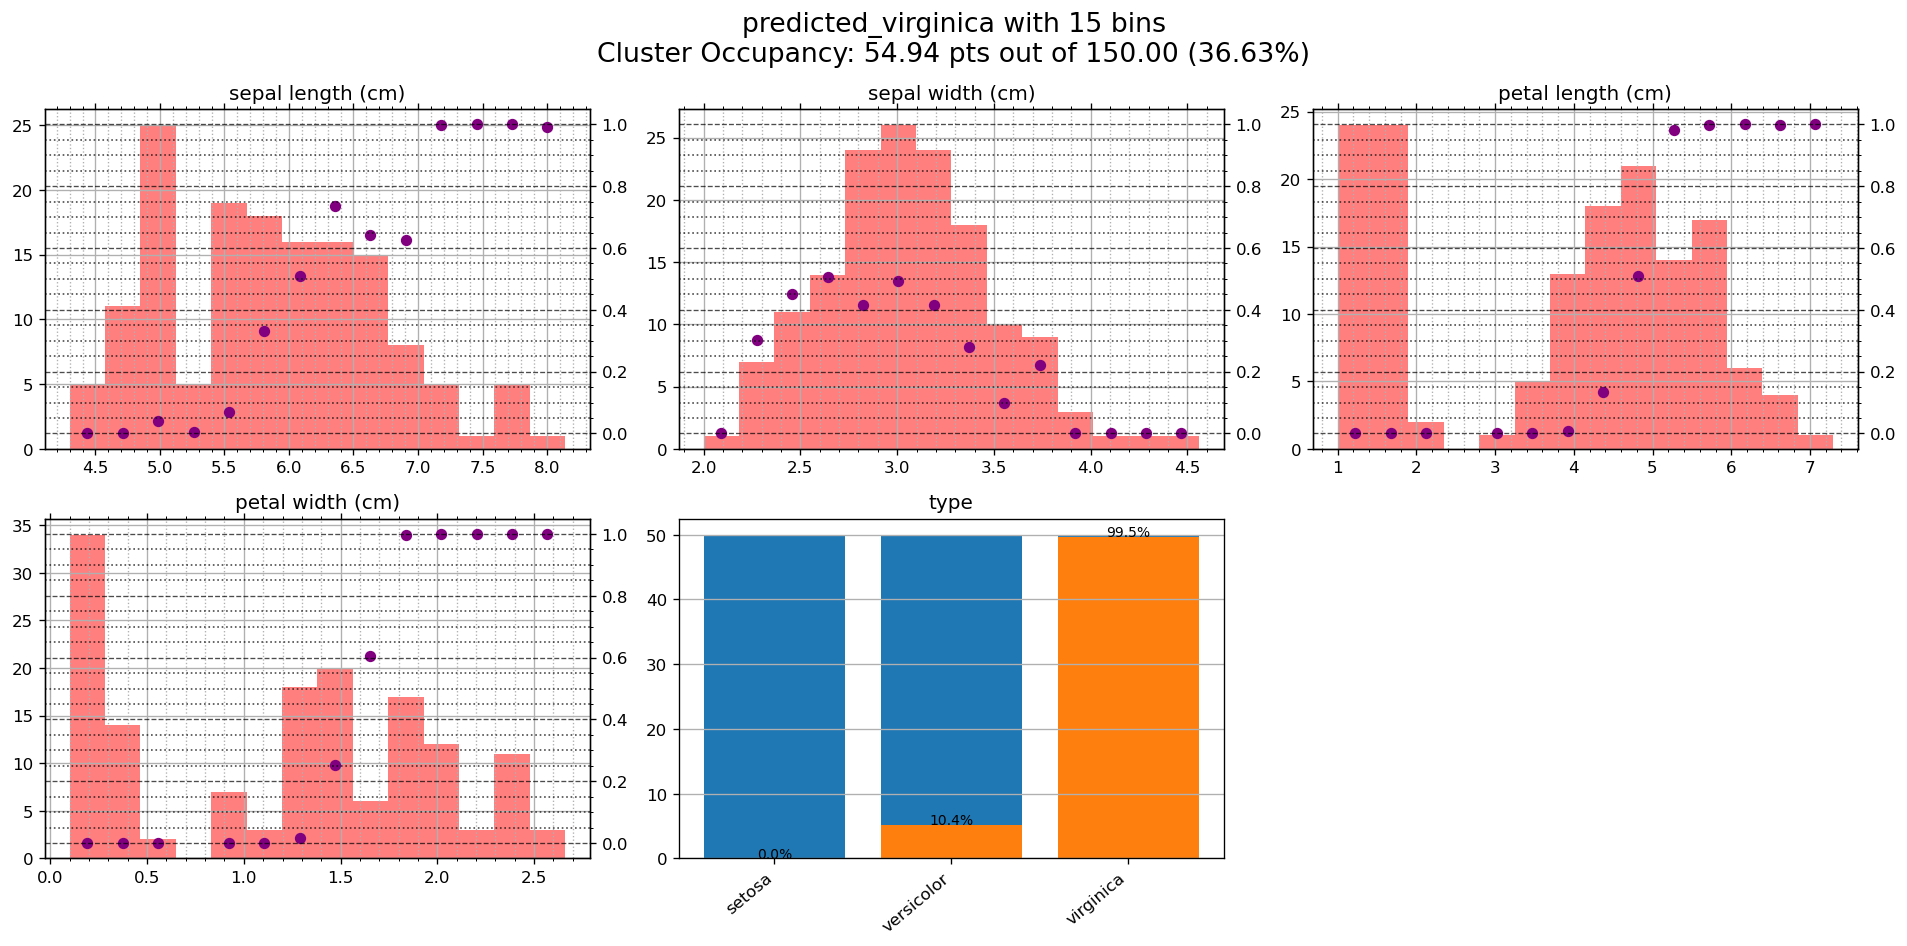

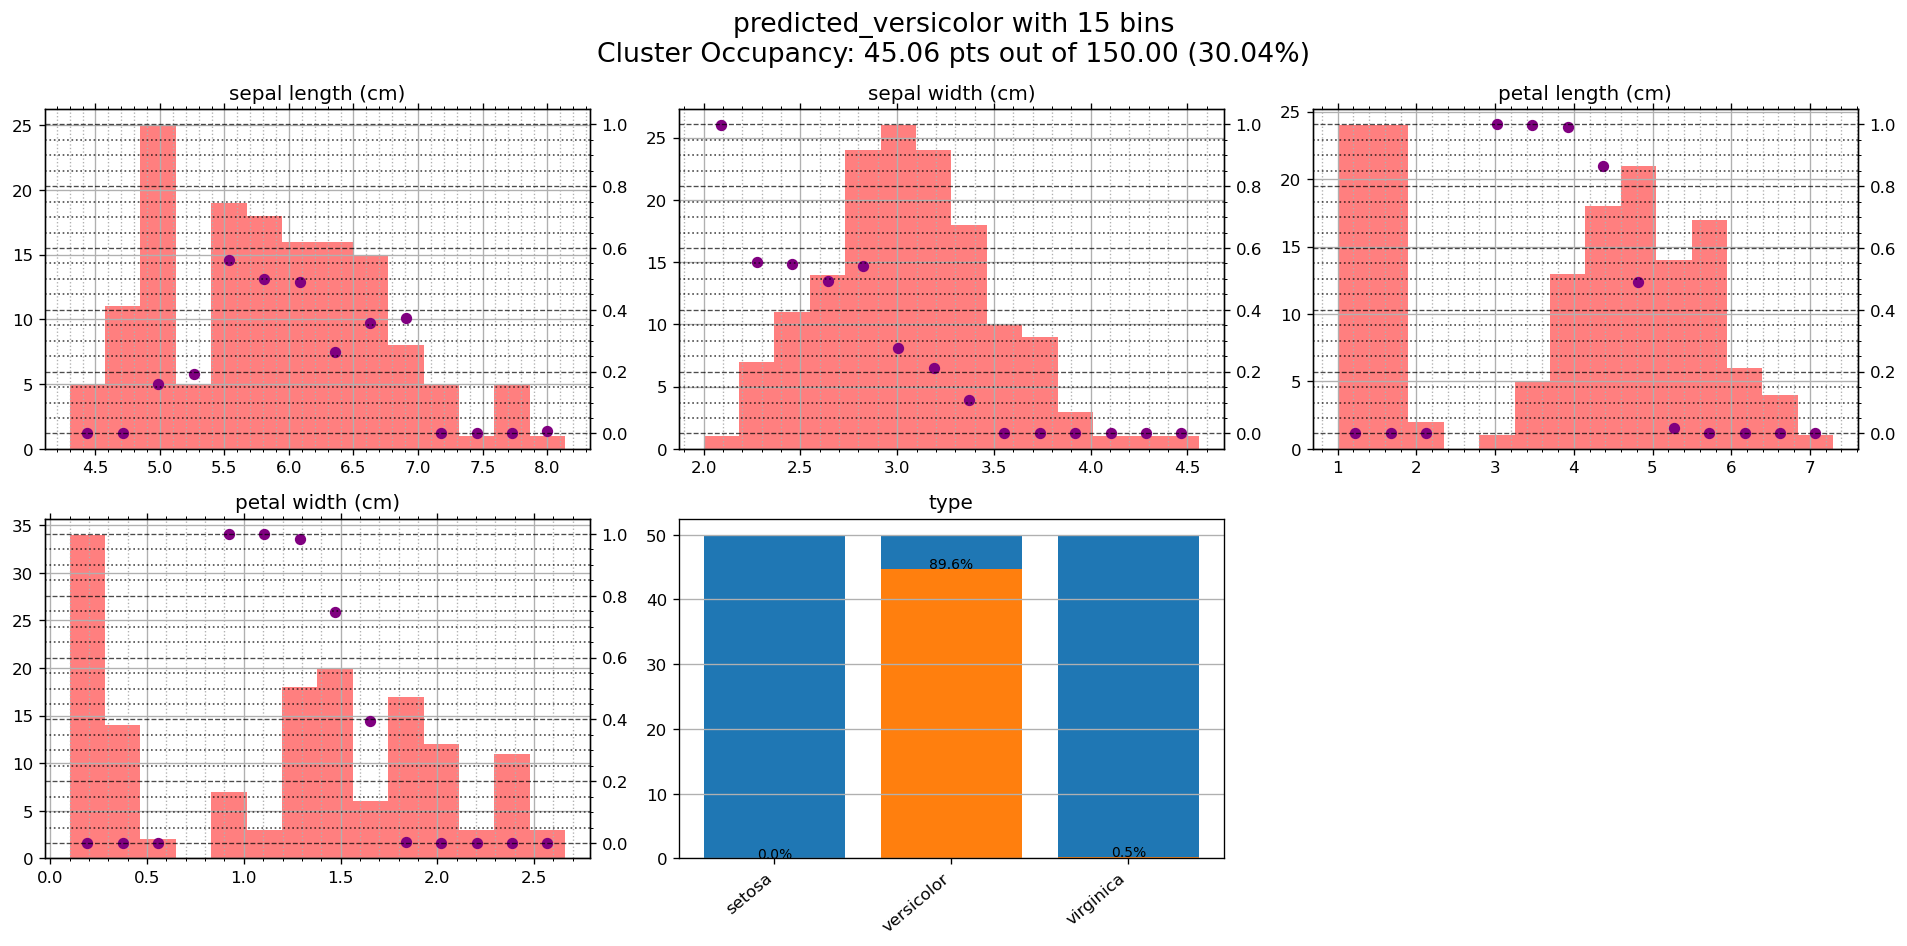

In [7]:
# also same as in hard clustering
init_names = {
    'predicted_virginica': 'petal length (cm)',
            # virginica has the highest avg in petal_length 
    'predicted_setosa': ('petal width (cm)', lambda x: -1*np.mean(x)),
            # setosa has the lowest avg in petal_width
    'predicted_versicolor': ('sepal width (cm)', lambda x: -1*np.mean(x)) 
            # versicolor has the lowest avg in sepal_width
             }
clust2 = clust(X, gm_preds,
               name_clusters = init_names)
clust2.hist1d(bins=15, hist_vars=hist_vars)

We can also study histograms in 2d (e.g. histograms over 2 variables simultaneously). Many other packages (matplotlib, seaborn, plotly, etc.) offer better ways to do this, but the advantage of this package is the ability to quickly create such plots *per cluster*.

Let's look at a pair of variables that have overlap in classes. Looking back at the original pairsplot, sepal width x sepal length seems a good option.

In order to use the probability for the heatmap (where the probability was given as a separate array in the constructor and is not in the class dataframe), use the kwarg hist_var='probability'.

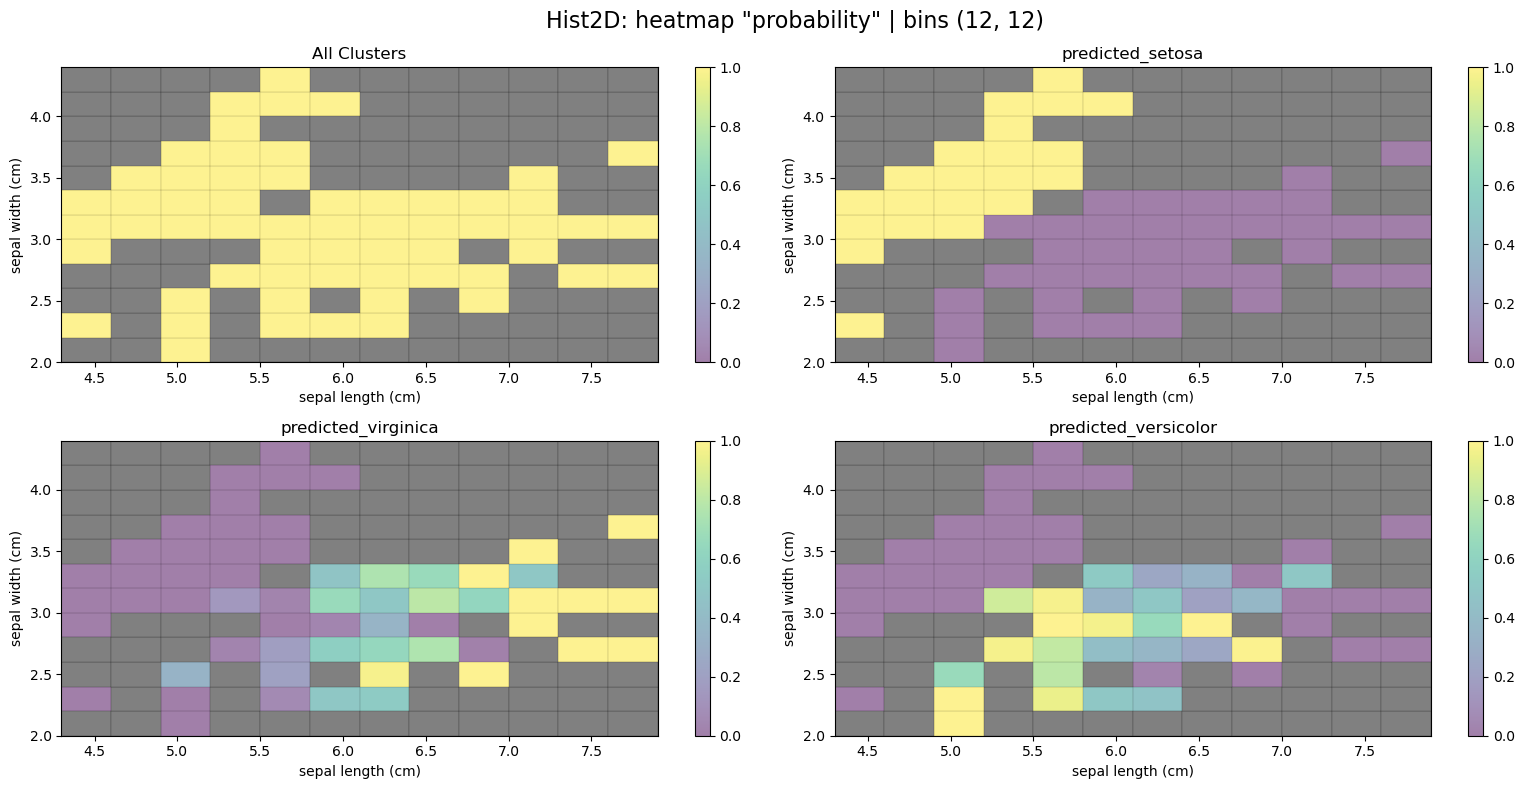

In [8]:
clust2.hist2d(
        histxy = ('sepal length (cm)','sepal width (cm)'),
        hist_var = 'probability',
        bins = (12,12)
             )

In the above, the setosa class is easily distinguishable from the amalgam of data occuring at moderate-to-low sepal width (< 3.5) and moderate-to-high sepal length (>5.5). A contributing factor to why the setosa predictions are perfect, but the virginica and versicolor have overlap.